# An introduction to image processing with NumPy

Image processing has an important role in data science and in science in general. The typical digit recognition problem is one (classic) example of image processing. The notion of *convolutional neural networks* is also a keep point in image processing based on machine learning algorithm. Another one, more recent, is the generative adversial neural network (GAN's) which are able to *generate* image of a given nature, after beeing properly trained. You can check out https://thispersondoesnotexist.com which shows generated image of people ... which doesn't exist.

The very first step is to understand how an image is encoded in numpy and how to manipulate it - even without talking about sophisticated algorithms. This is the goal of this notebook, which is split into three different sections: 
  
  1. **Basic investigations:** load and plot an image, get the histogram of pixel values for each channel, grey scale, croping, ...
  2. **Numerical operations:** addition, subtraction, masking some pixel based on a given condition, ...
  3. **Applying basic filters:** image split in blocks versus windows, bluring, sharpening, border detection, ...
  
Note that for there is (at least) one python pacakage dedicated to image processing: [Pillow](https://pillow.readthedocs.io/en/stable/). I choose to not use it here in order to not increase the number of tools (very easy to do in python), so *only NumPy and matplotlib will be used in this notebook*. However, if you are intersted in doing intensive image processing, I would recommand to look at pillow. Another tool, more oriented toward machine learning and computer vision, is [OpenCV](https://opencv-python-tutroals.readthedocs.io/en/latest/index.html) - good to keep in mind depending on your applications.

## Basic investigations

An image is a numpy array of 8-bits integers with a shape `(Nx, Ny, 3)` with `Nx` (`Ny`) pixels in the `x` (`y`) direction and three colors being a interger in $[0, 255]$ interval (RBG). The low pixel values correspond to dark areas while values close to %255$ are clear pixels. An usual image format (png, jpg, ...) can be loaded as numpy array using `plt.imread()` function:

In [268]:
# Usual import
import numpy as np
import matplotlib.pyplot as plt

# Load a test image
im = plt.imread('../data/image_test.jpg')

Indeed, we can investigate the numpy array we loaded:

In [269]:
# Print caracteristics
print('Object    : {}'.format(type(im)))
print('Shape     : {}'.format(im.shape))
print('Data type : {}'.format(im.dtype))

# Print the values of four first pixels along x (for y=0):
print('pixels(x<5, y=0): \n{}'.format(im[0:4, 0, :]))

Object    : <class 'numpy.ndarray'>
Shape     : (3008, 4008, 3)
Data type : uint8
pixels(x<5, y=0): 
[[18 18  8]
 [21 21  9]
 [31 31 19]
 [29 29 17]]


### Plotting

The obvious first thing we want to do with an image is to see it! This can be acheived using `plt.imshow()` function. Below, we write a function which uses `plt.imshow()`, with arbitrary figure size keeping the figure ratio:

In [270]:
def plot_image(im, h=5, **kwargs):
    '''
    Helper function to plot an image.
    im: np.array
    '''
    lx, ly = im.shape[:2]
    w = (ly/lx)*h
    plt.figure(figsize=(w,h))
    plt.imshow(im, interpolation=None, **kwargs)

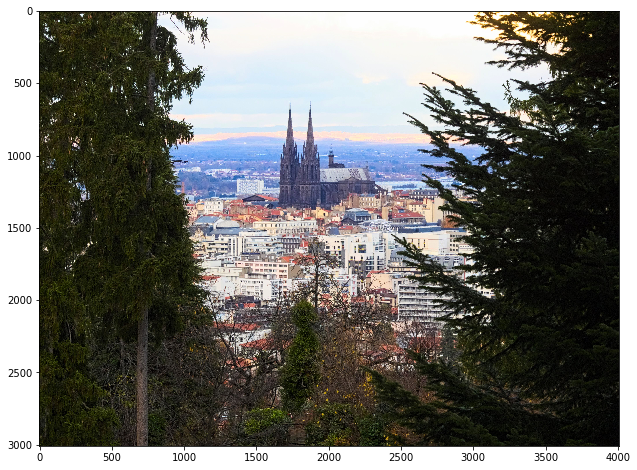

In [271]:
plot_image(im, h=8)

### Histograms

The histogram of an image is often shown on a camera or on post-processing picture software. This allow to appreciate how all pixels are distributed in term of intensity. This can be obtained with a rather straightforward function:

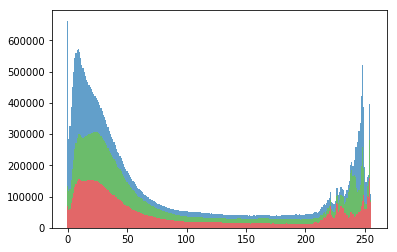

In [272]:
def plot_histogram(image):
    
    # Get the 2D array for each of the three colors, and flat it.
    pixels = [p.ravel() for p in np.array_split(image, 3, axis=2)]
    
    # Produce the histogram for each color and stack them
    style_hist = {'bins': np.arange(-0.5, 256.5, 1.0), 'alpha': 0.7, 'stacked':True}
    plt.hist(pixels, color=['tab:red', 'tab:green', 'tab:blue'], **style_hist)
    return
    
plot_histogram(im)

### Color and gray scale

This is also possible to plot each channel (color) separately. First, we can crop the picture to focus on the intersting part of it: the Clermont-Ferrand cathedral. Since the image is a numpy array, croping is just taking a sub-array using numpy indexing:

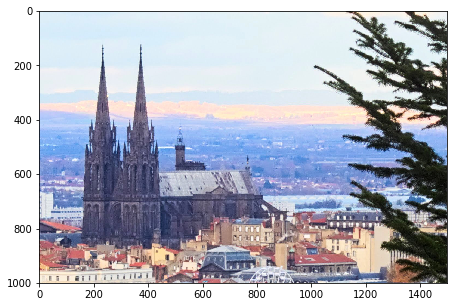

In [275]:
image = im[500:1500, 1500:3000]
plot_image(image)

For instance, we can plot the histogram of this new image and check that the dark parts corresponding to surrounding trees (low values) are gone:

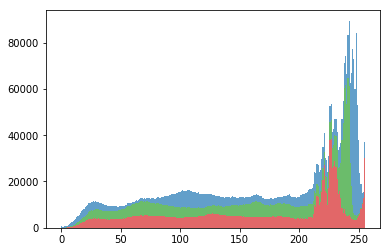

In [276]:
plot_histogram(image)

In order to investigate how the colors are spatially distributed, one can plot each channel sperately using the appropriated color map. This this what the next function does:

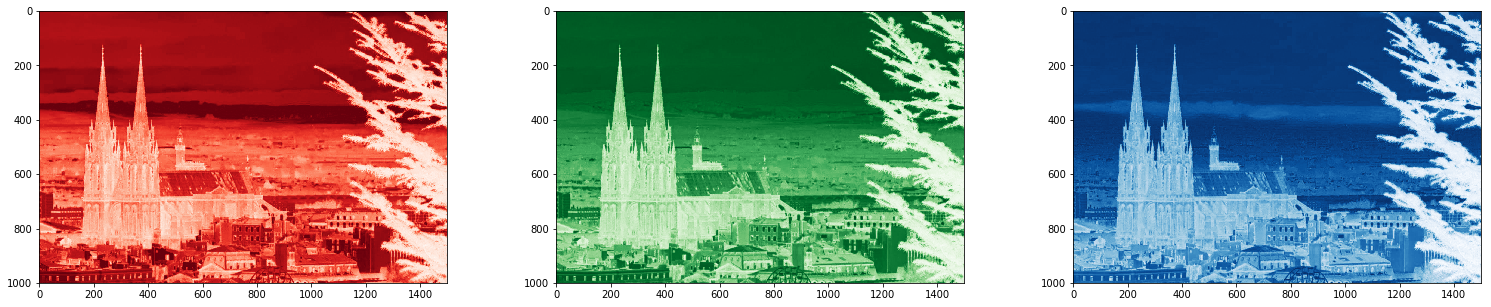

In [277]:
def plot_RGB(image):
    '''Plot each color channel'''
    
    # Get each color channel
    R, G, B = image[...,0], image[...,1], image[...,2]
    
    # Figure shape preserving the image ratio
    lx, ly = image.shape[:2]
    w = (ly/lx)*5
    fig = plt.figure(figsize=(w*3.5,5))
    
    # One subplot per channel (Nrow, Ncol, Nplot)
    for i, (pixel, color) in enumerate(zip([R, G, B], ['Reds', 'Greens', 'Blues'])):
        plt.subplot(1, 3, i+1)
        plt.imshow(pixel, interpolation=None, cmap=color)
    return
    
plot_RGB(image)

Another usual operation is to switch from colored to gray scale picture. This can be done in several ways (check for *e.g.* the corresponding [wikipedia article](https://en.wikipedia.org/wiki/Grayscale)), but one which is relatively simple to implement is based on luminensce preservation:

In [278]:
def get_gray_scale(image):
    
    # Get RGB individual values
    R, G, B = image[...,0], image[...,1], image[...,2]

    # Get gray scale from RGB colors: PIX = 0.299 R + 0.587 G + 0.114 B
    pixels = np.array(0.299*R + 0.587*G + 0.114*B, dtype=np.uint8)

    # Replace each channel by this gray scale
    im_gs = np.stack([pixels, pixels, pixels], axis=2)
    
    # Retrun the gray image
    return im_gs

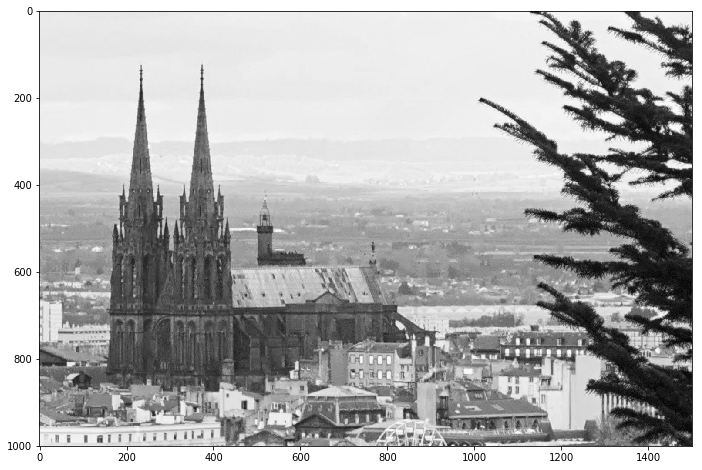

In [279]:
# Get the gray scale image
gray_image = get_gray_scale(image)

# Plot the result
plot_image(gray_image, h=8)

## Numerical operations on images

Since images are numpy arrays, we can perform numerical operations very easily. Not all of them have a proper meaning though, but it is intersting to explore the possibilities. First, we define two images which are the Clermont-Ferrand cathedral slightly shifted:

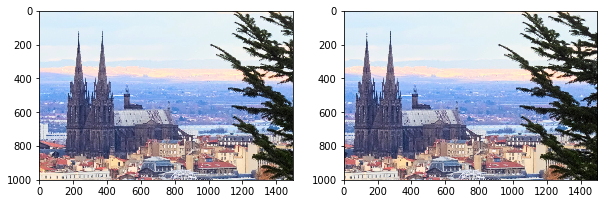

In [282]:
# Create the two images
image1 = im[500:1500, 1500:3000]
image2 = im[500:1500, 1600:3100]

# Plot the two images side-by-side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.subplot(1, 2, 2)
plt.imshow(image2);

What if we add or subtract these pictures? One has to define what happens if the sum (or the difference) is out of the permitted range $[0, 255]$. Let's take the following convention: if the pixel is below 0, we set it to 0 and if it is above 255, we set it to 255. This can be done by taking the image with float (allowing above values) and operate the truncation after end. The two following functions implement this "image addition/subtraction":

In [283]:
def add_pictures(im1, im2):
    s = im1.astype(np.float) + im2.astype(np.float)
    s[s>255] = 255
    s[s<0] = 0
    return s.astype(np.uint8)

def subtract_pictures(im1, im2):
    s = im1.astype(np.float) - im2.astype(np.float)
    s[s>255] = 255
    s[s<0] = 0
    return s.astype(np.uint8)

Let's try to plot the added and subtracted images:

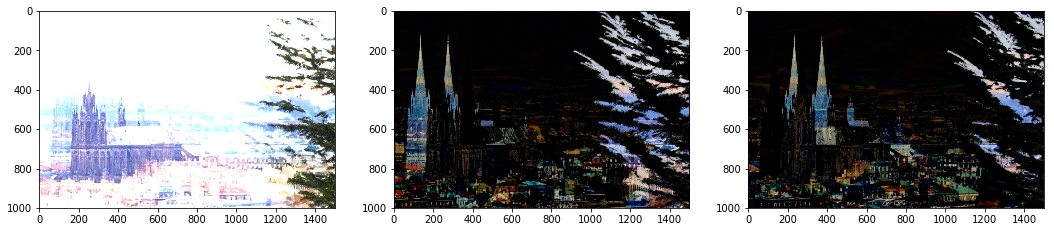

In [284]:
# Perform the operations
s12 = add_pictures(image1, image2)
d12 = subtract_pictures(image1, image2)
d21 = subtract_pictures(image2, image1)

# Plot the results side-by-side
plt.figure(figsize=(18, 7))
plt.subplot(1, 3, 1)
plt.imshow(s12)
plt.subplot(1, 3, 2)
plt.imshow(d12)
plt.subplot(1, 3, 3)
plt.imshow(d21);

When we sum the two picture, we get something very bright (as expected) and we see the echo of the cathedral. After the subtraction (middle), we still see the echo but we get something every dark. The last plot show the other difference, looking quite cool especially at the bottom of the Cathedral!

Another nice operation we can easily do with NumPy is to mask pixel statisfying a given condition. Let say we want to mask all pixel which as its red level higher than it's blue level summed to the green level:

In [285]:
# Get the copy of colors (to be modifed latter) 
r, g, b = image[...,0].copy(), image[..., 1].copy(), image[..., 2].copy()

# Get the mask
th = add_pictures(g, b)
to_black = r>=th

# Perform the mask
r[to_black] = 0
g[to_black] = 0
b[to_black] = 0

One can also decide to set to white the too dark regions, say `r+g+b<=60`, *whithout touching the previous pixels*:

In [286]:
# Get the new indices to set to white
to_white = r+b+g<=60

# White only pixel that were didn't touch by the previous mask
to_white = to_white * ~to_black

# Perform the whitening
r[to_white] = 255
g[to_white] = 255
b[to_white] = 255

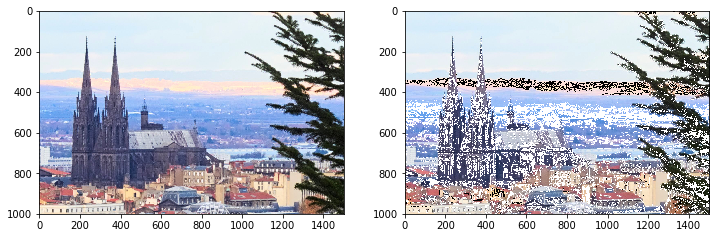

In [287]:
# Combine the colors back
image_masked = np.stack([r, g, b], axis=2)

# Plot the results side-by-side
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.subplot(1, 2, 2)
plt.imshow(image_masked);

## Image filters with NumPy


### Kernels, blocks and sliding window

In image processing, a filter is a small 2D array $n\times n$ (also called *kernel*) which is used to modify the value of each pixel using a *convolution* between a portion of the image and the kernel. These portions can be either use every pixel only once - split the image in $(n \times n)$ blocks - or they can use every pixel several times - sliding $(n \times n)$ overlapping windows. The mathematical operation behind the name convolution is a simple sum over all elements from the window, waited by the elements of the kernel.

In order to better understand the concept of kernels, blocks and windows, let's now take an exemple of a `12x12` image and build up both the blocks and sliding windows:

In [288]:
# Image definition
image = np.arange(12*12).reshape(12, 12)
print('image = \n{}'.format(image))

# Build-up 3x3 independant blocks
step3 = range(0, 12, 3)
blocks_3x3 = np.array([image[i:i+3, j:j+3] for i in step3 for j in step3])
blocks_3x3 = blocks_3x3.reshape(4, 4, 3, 3) # Organize the 16 blocks into a 4x4 grid
print('\nBlock[1, 1] = \n{}'.format(blocks_3x3[1, 1]))

# Built-up 3x3 windows for pixel far from the border (to avoid technical issues)
windows_3x3 = np.array( [image[i-1:i+2, j-1:j+2] for i in range(1, 11) for j in range(1, 11)] )
windows_3x3 = windows_3x3.reshape(10, 10, 3, 3) # Organize the 100 blocks into a 10x10 grid
print('\nWindow[3, 2] = \n{}'.format(windows_3x3[3, 2]))

image = 
[[  0   1   2   3   4   5   6   7   8   9  10  11]
 [ 12  13  14  15  16  17  18  19  20  21  22  23]
 [ 24  25  26  27  28  29  30  31  32  33  34  35]
 [ 36  37  38  39  40  41  42  43  44  45  46  47]
 [ 48  49  50  51  52  53  54  55  56  57  58  59]
 [ 60  61  62  63  64  65  66  67  68  69  70  71]
 [ 72  73  74  75  76  77  78  79  80  81  82  83]
 [ 84  85  86  87  88  89  90  91  92  93  94  95]
 [ 96  97  98  99 100 101 102 103 104 105 106 107]
 [108 109 110 111 112 113 114 115 116 117 118 119]
 [120 121 122 123 124 125 126 127 128 129 130 131]
 [132 133 134 135 136 137 138 139 140 141 142 143]]

Block[1, 1] = 
[[39 40 41]
 [51 52 53]
 [63 64 65]]

Window[3, 2] = 
[[38 39 40]
 [50 51 52]
 [62 63 64]]


For instance, the number `39` can only be on a edge of a block (used once) while it can be everywhere for the sliding windows (used several times). Let's now define a `3x3` kernel and apply it to `blocks_3x3[1,1]`:

In [289]:
# Definition
kernel = np.arange(9).reshape(3, 3)/20
print('kernel = \n{}'.format(kernel))

# Convolution with the block[1, 1]
this_block = blocks_3x3[1, 1]
new_pixel = np.sum(kernel * this_block)
print('\nProduct of elements = \n{}'.format(kernel * this_block))
print('\nNew pixel = {:.1f} (vs an old pixel of {})'.format(new_pixel, this_block[1, 1]))

kernel = 
[[0.   0.05 0.1 ]
 [0.15 0.2  0.25]
 [0.3  0.35 0.4 ]]

Product of elements = 
[[ 0.    2.    4.1 ]
 [ 7.65 10.4  13.25]
 [18.9  22.4  26.  ]]

New pixel = 104.7 (vs an old pixel of 52)


Let's now apply the kernel defined above to both blocks and sliding windows. We can also represent the image before filter, after block-based filter and window-based filter.

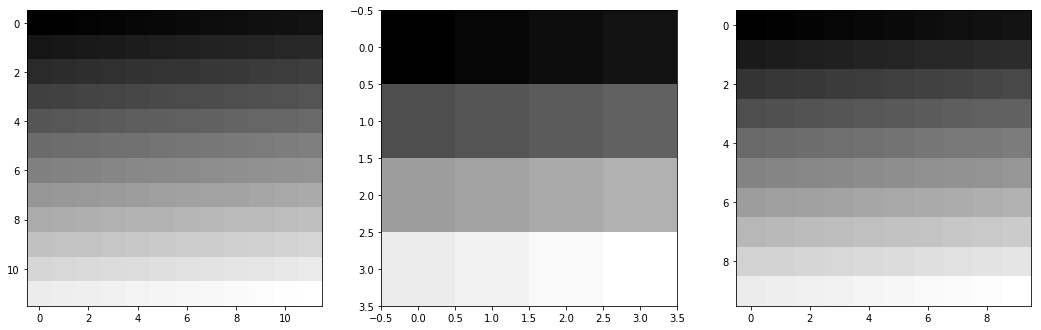

In [290]:
# Apply block-based filter
block_filtered = np.sum(blocks_3x3*kernel[np.newaxis, np.newaxis], axis=(2, 3))
block_filtered[block_filtered>255]=255
block_filtered[block_filtered<0]=0

# Apply window-based filter
window_filtered = np.sum(windows_3x3*kernel, axis=(2, 3))
window_filtered[window_filtered>255]=255
window_filtered[window_filtered<=0]=0

# Plot the results side-by-side
plt.figure(figsize=(18, 7))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(block_filtered, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(window_filtered, cmap='gray');

**Comment.** The block view is not too gridy in memory but the the windows view can explode quite rapidely. Indeed, for a kernel of $n \times n$, the windows view is $n^2$ larger than the original array. If you manipulate millions of images this can be problematic.

### Generalisation to RGB image

We need to consider 3 colors to apply a filter, which has some implication in term of broadcasting structure. First, let's define a dummy RGB image using a meshgrid (careful x and y are reversed wrt imshow) and three function for each color:

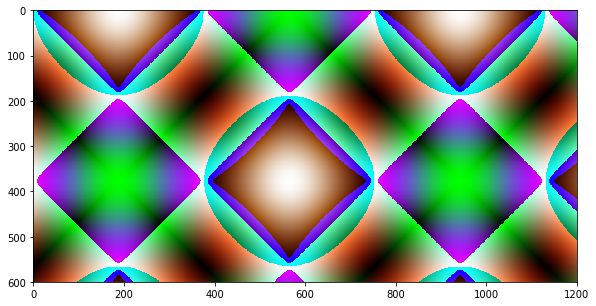

In [384]:
# Create a shaped image
def get_dummy_image(n=600, ny=1200):
    X, Y = np.meshgrid(np.linspace(0, 10, 1200), np.linspace(0, 5, 600))
    f = lambda n: np.abs(np.sin(X)**n+np.cos(Y)**n)
    im = np.stack([f(1), f(2), f(3)], axis=2)*255
    return im.astype(np.uint8)

im = get_dummy_image()
plot_image(im)

In [373]:
# Kernel definition
kernel = np.ones(shape=(6, 6))
kernel = kernel/np.sum(kernel)

# Kernel application with the proper broadcasting over colors
new_pixel = np.sum(im[0:6, 0:6, :]*kernel[:,:,np.newaxis], axis=(0,1))
print(new_pixel)

[ 46.47222222 254.44444444 254.16666667]


### Block view: intuitive but inefficient approach

In [375]:
def apply_filter_one_block(im, ma, i, j):
    dx, dy = ma.shape
    start_i, end_i = i*dx, (i+1)*dx
    start_j, end_j = j*dy, (j+1)*dy
    indices = (slice(start_i, end_i), slice(start_j, end_j), slice(None, None))
    pixel = np.sum(im[indices]*ma[:, :, np.newaxis], axis=(0, 1))
    return pixel / (ma.size*255)

In [376]:
apply_filter_one_block(im, kernel, 1, 1)

array([0.00173082, 0.02461571, 0.02750847])

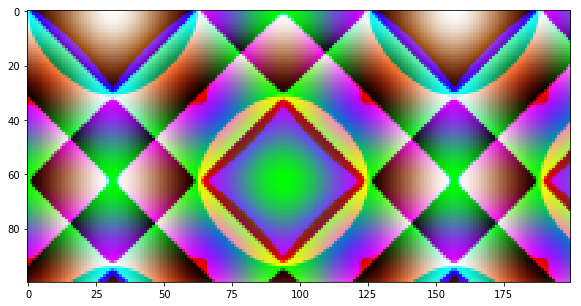

In [377]:
# 6x6
kernel = np.ones(shape=(6, 6))
im_comp = np.array([[apply_filter_one_block(im, kernel, i, j) for j in range(0, 200)] for i in range(0, 100)])
plot_image(im_comp)

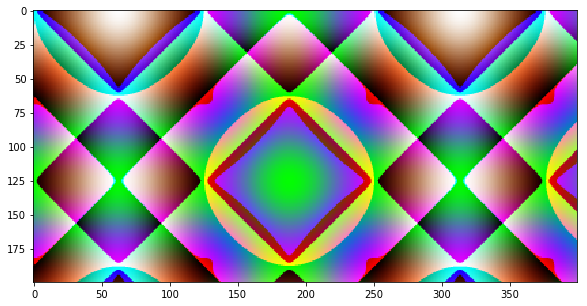

In [378]:
# 3x3
kernel = np.ones(shape=(3, 3))
im_comp = np.array([[apply_filter_one_block(im, kernel, i, j) for j in range(0, 400)] for i in range(0, 200)])
plot_image(im_comp)

### Block view: faster approach with `np.as_strided()` numpy logic

The idea is to first turn the array of dimensio `(Nx, Ny, Ncolor)` into `(Nx_new, Ny_new, Nx_mask, Ny_mask, Ncol)` and then simply multiply and sum over the axis 2 and 3. In order to do this, the most intuitive approach is to use `np.reshape()` function. It does give the proper shape (by construction) but not the proper data. The other approach is quite advance but also quite powerful: `numpy.lib.stride_tricks.as_strided()`. Strides are basically jump in memory to switch from one element to another. It's not yes all clear but this *doesn't duplicate the data but rather view them as a different way*. This is the approach behind the broadcasting. **This is by far the fastest approach**.

In [385]:
def method_strides(image, mask):
    '''Taken (and simplified/adapated) from scikit-image/skimage/util/shape.py'''
    
    from numpy.lib.stride_tricks import as_strided

    # Get the new shape
    m_shape, image_shape = np.array(mask.shape), np.array(image.shape)
    new_shape = tuple(image_shape[:2] // m_shape) + tuple(m_shape) + (image_shape[-1],)
    
    # Get the new strides
    new_strides = tuple(image.strides[:2] * m_shape) + image.strides  # --> quesaco ?!
    
    # Get the new blocked image (Nx_new, Ny_new, Nx_mask, Ny_mask, 3)
    blocked_image = as_strided(image, shape=new_shape, strides=new_strides, writeable=False)
    
    # Apply the mask with the proper broadcasting
    mask_reshaped = mask[np.newaxis, np.newaxis, :, :, np.newaxis]
    return np.mean(blocked_image*mask_reshaped, axis=(2, 3), dtype=np.int)

image = get_dummy_image(30, 60)
mask = np.ones(shape=(3, 3))
res = method_strides(image, mask)

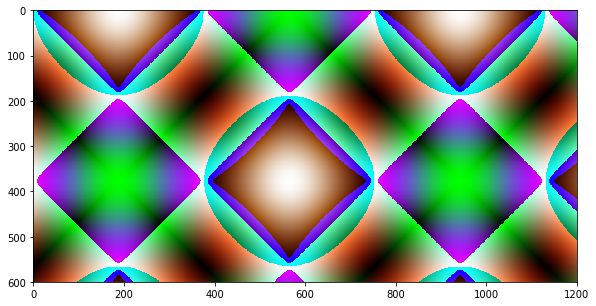

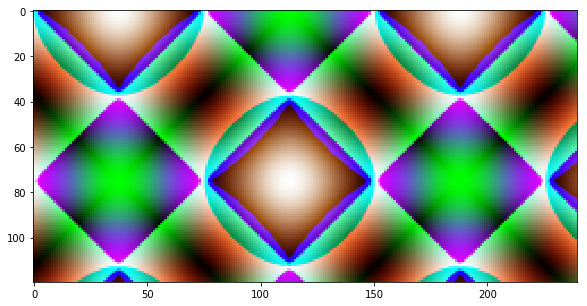

In [386]:
image = get_dummy_image()
mask = np.ones(shape=(5, 5))
res = method_strides(image, mask)
plot_image(image)
plot_image(res)

### Apply different filters on  the test image

**Noisy filter**.

In [29]:
# Re-load the image for a fresh start!
im = plt.imread('../data/image_test.jpg')
image = im[500:1500, 1500:2500]

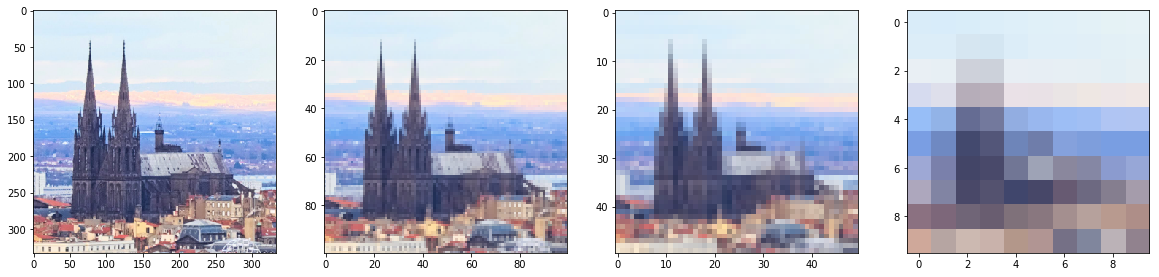

In [30]:
plt.figure(figsize=(20, 5))

for i, n in enumerate([3, 10, 20, 100]):
    kernel = np.ones(shape=(n, n))
    compressed_image = method_strides(image, kernel)
    plt.subplot(1, 4, i+1)
    plt.imshow(compressed_image)

## Few typical filters

### Preamble: convolution and filters

In [32]:
# test image
image = im[500:1500, 1500:2500]

def clean_image(image):
    image[image < 0] = 0
    image[image > 255] = 255
    return image.astype(np.int)

def normalize_filter(filter):
    if np.sum(filter) != 0:
        return filter/np.sum(filter)
    else:
        return filter

def apply_filter(image, filter):
    from scipy import signal
    
    # Performing 2D convolution
    args = {'in2': filter, 'mode': 'same', 'boundary': 'fill', 'fillvalue': 0}
    filtered_image = np.array([signal.convolve2d(image[...,i], **args) for i in np.arange(image.shape[2])])
    
    # Channel (color) is first -> moving it as last axis
    filtered_image = np.swapaxes(filtered_image, 0, 1)
    filtered_image = np.swapaxes(filtered_image, 2, 1)
    
    # Result
    return clean_image(filtered_image)

## Border detection

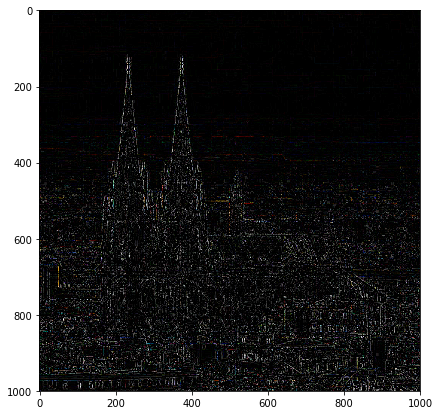

In [33]:
filter_border = np.array([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]
])

filter_border = normalize_filter(filter_border)
borders= apply_filter(image, filter_border)
plot_image(borders, h=7)

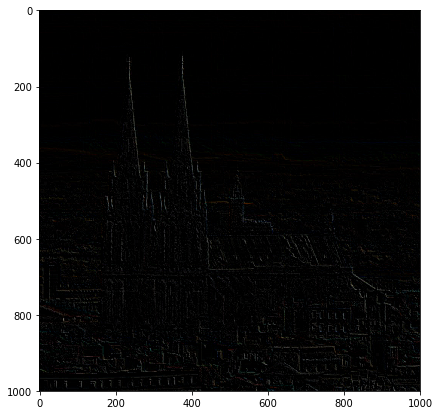

In [34]:
# Border which are direction-dependent: top-right
filter_topright = np.array([
    [ 0,  0, -1],
    [ 0,  1,  0],
    [ 0,  0,  0]
])
filter_topright = normalize_filter(filter_topright)
borders= apply_filter(image, filter_topright)
plot_image(borders, h=7)

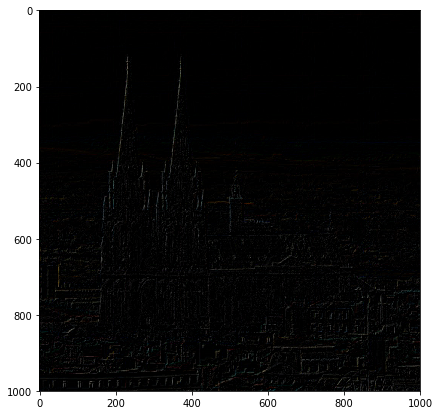

In [35]:
# Border which are direction-dependent: top-left
filter_topleft = np.array([
    [ -1,  0,  0],
    [  0,  1,  0],
    [  0,  0,  0]
])
filter_topleft = normalize_filter(filter_topleft)
borders = apply_filter(image, filter_topleft)
plot_image(borders, h=7)

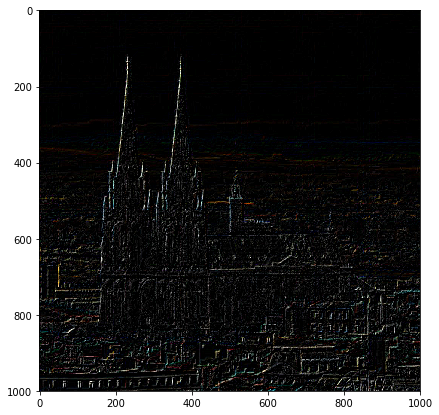

In [36]:
# Playing with intensity of the border
filter_topleft = np.array([
    [ -3,  0,  0],
    [  0,  3,  0],
    [  0,  0,  0]
])
filter_topleft = normalize_filter(filter_topleft)
borders = apply_filter(image, filter_topleft)
plot_image(borders, h=7)

## Sharpen filter

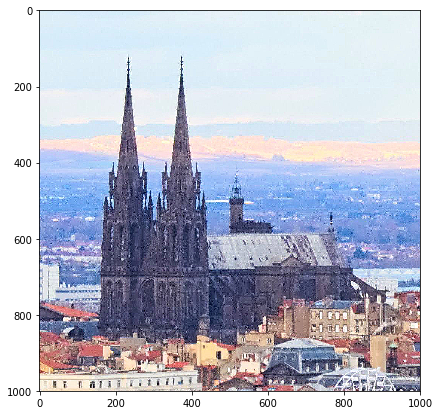

In [37]:
filter_sharpen = np.array([
    [  0, -1,  0],
    [ -1,  5, -1],
    [  0, -1,  0]
])
filter_sharpen = normalize_filter(filter_sharpen)
plot_image(apply_filter(image, filter_sharpen), h=7)